In [1]:
import pandas as pd
import awswrangler as wr
from mlops.const import GLUE_DATABASE

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 

## 学習データと推論データを比較

In [55]:
sql = """
    select *
    from mlops_db.{table_name}
    where model_name = '{model_name}' 
      and model_version = '{model_version}'
"""

In [71]:
df_train = wr.athena.read_sql_query(
    sql.format(table_name='train_log', model_name='sgd_classifier_ctr', model_version='20250502213739'), 
    database=GLUE_DATABASE, 
    ctas_approach=False,
)

In [57]:
df_predict = wr.athena.read_sql_query(
    sql.format(table_name='predict_log', model_name='sgd_classifier_ctr', model_version='20250502213739'), 
    database=GLUE_DATABASE, 
    ctas_approach=False,
)

In [40]:
df_train.head()

,impression_id,logged_at,user_id,app_code,os_version,is_4g,is_click,impression_hour,impression_day,impression_weekday,...,item_id,device_type,item_price,category_1,category_2,category_3,product_type,model_name,model_version,data_type
0,72ab9a774ba5a9d34d2a28552745f53f,2018-12-04 13:51:00,17195,296,latest,1,0,13,4,1,...,71700,android,1424,17,39,297,1630,sgd_classifier_ctr,20250502213739,test
1,37d276bd524d8a4d1fec4127f59270bb,2018-12-04 13:51:00,38162,190,old,1,0,13,4,1,...,-1,null,-1,-1,-1,-1,-1,sgd_classifier_ctr,20250502213739,test
2,25bc8c510cc5b395532613a85dcaeacf,2018-12-04 13:51:00,48873,7,latest,1,0,13,4,1,...,72853,android,1856,13,78,129,10326,sgd_classifier_ctr,20250502213739,test
3,8b2115f9a25370cbf851a0490a94b688,2018-12-04 13:51:00,21667,3,old,1,0,13,4,1,...,-1,null,-1,-1,-1,-1,-1,sgd_classifier_ctr,20250502213739,test
4,8071e5a89be9847543cdc97783a32eab,2018-12-04 13:52:00,60497,207,intermediate,0,0,13,4,1,...,55096,android,7557,17,8,279,1032,sgd_classifier_ctr,20250502213739,test


In [41]:
df_predict.head()

,impression_hour,impression_day,impression_weekday,user_id,app_code,os_version,is_4g,previous_impression_count,previous_view_count,item_id,...,container_id,container_name,source,ecs_cluster,ecs_task_arn,ecs_task_definition,partition_0,partition_1,partition_2,partition_3
0,13,18,1,38757,5,latest,1,4,10,33633,...,729c6a239282417498e7d0f1002b78aa-3525156039,predict-api,stdout,mlops-ecs,arn:aws:ecs:ap-northeast-1:559802578070:task/m...,predict-api-main:8,2025,05,03,04
1,13,18,1,68522,386,intermediate,1,-1,1,7522,...,729c6a239282417498e7d0f1002b78aa-3525156039,predict-api,stdout,mlops-ecs,arn:aws:ecs:ap-northeast-1:559802578070:task/m...,predict-api-main:8,2025,05,03,04
2,13,18,1,15409,61,old,0,4,4,102341,...,729c6a239282417498e7d0f1002b78aa-3525156039,predict-api,stdout,mlops-ecs,arn:aws:ecs:ap-northeast-1:559802578070:task/m...,predict-api-main:8,2025,05,03,04
3,13,18,1,40490,207,old,1,4,1,67695,...,729c6a239282417498e7d0f1002b78aa-3525156039,predict-api,stdout,mlops-ecs,arn:aws:ecs:ap-northeast-1:559802578070:task/m...,predict-api-main:8,2025,05,03,04
4,13,18,1,73505,127,latest,1,-1,2,118458,...,729c6a239282417498e7d0f1002b78aa-3525156039,predict-api,stdout,mlops-ecs,arn:aws:ecs:ap-northeast-1:559802578070:task/m...,predict-api-main:8,2025,05,03,04


In [85]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_distribution(df_train: pd.DataFrame, df_predict: pd.DataFrame, column: str, bins:int=30) -> None:
    # 両方のデータセットの最小値と最大値を計算
    min_val = min(df_train[column].min(), df_predict[column].min())
    max_val = max(df_train[column].max(), df_predict[column].max())
    
    # 共通のビンを作成
    bin_edges = np.linspace(min_val, max_val, bins + 1)

    # ヒストグラムの描画
    plt.figure(figsize=(10, 6)) 
    sns.histplot(
        x=df_train[column], 
        bins=bin_edges,
        label='Train', 
        stat='density',
        alpha=0.5,
    )
    
    sns.histplot(
        x=df_predict[column], 
        bins=bin_edges,
        label='Predict', 
        stat='density',
        alpha=0.5,
    )
    
    # グラフの設定
    plt.title(f'{column} Distribution')
    plt.xlabel(column)
    plt.ylabel('Density')
    plt.legend()
    
    # レイアウトの調整
    plt.tight_layout()
    plt.savefig('dist.png')
    plt.show()

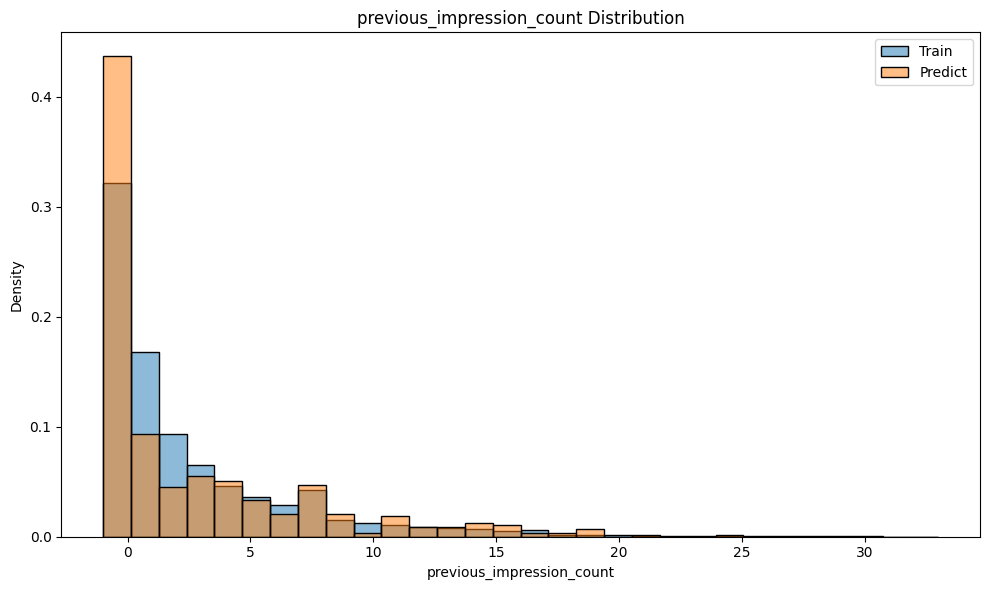

In [76]:
plot_distribution(df_train, df_predict, 'previous_impression_count')

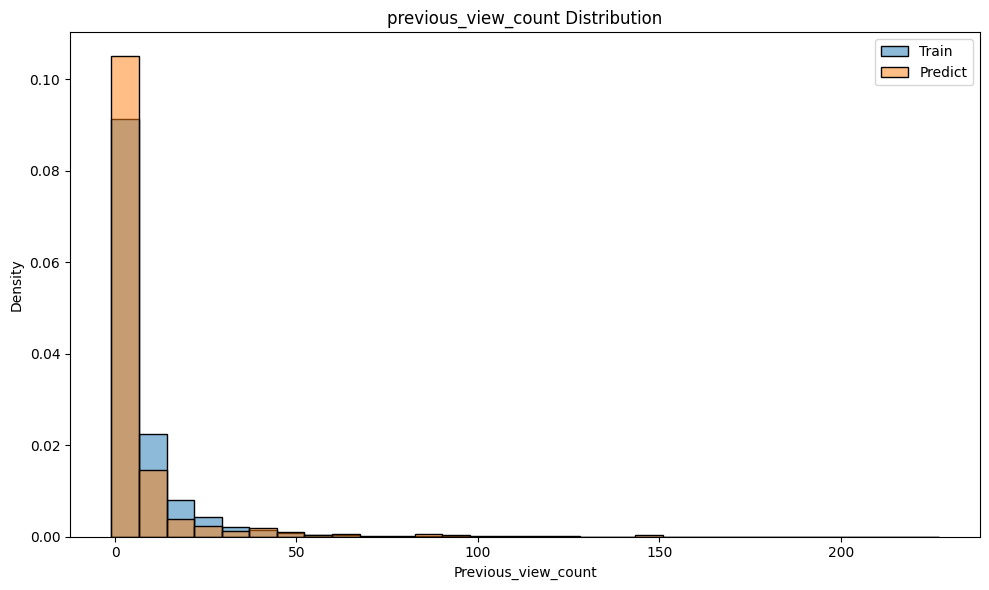

In [65]:
plot_distribution(df_train, df_predict, 'previous_view_count')

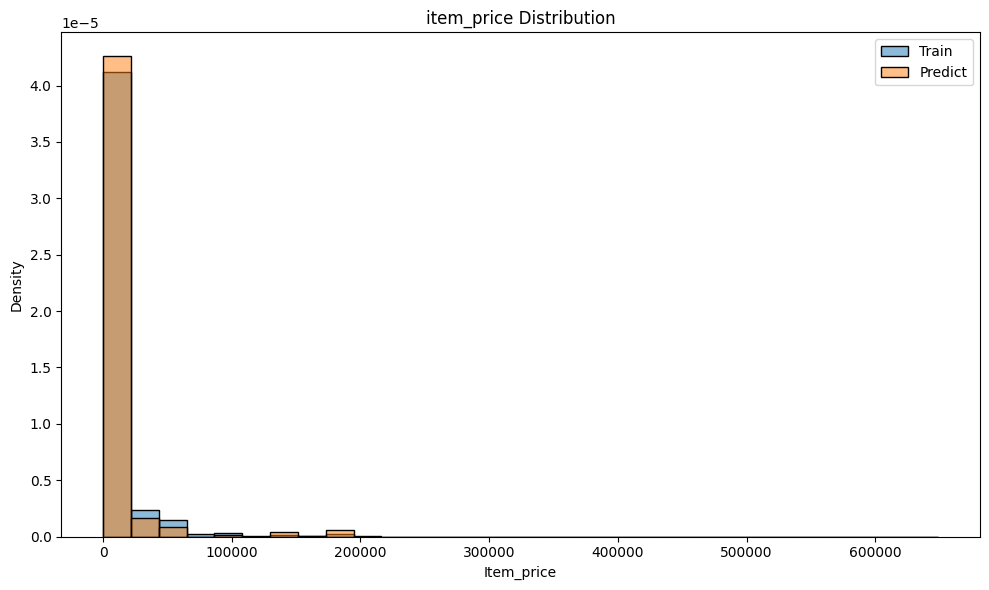

In [66]:
plot_distribution(df_train, df_predict, 'item_price')

In [79]:
def compare_statistics(df_train, df_predict, column='price'):
    # 記述統計量の計算
    train_stats = df_train[column].describe()
    predict_stats = df_predict[column].describe()
    
    # 結果を結合
    comparison_df = pd.DataFrame({
        'train': train_stats,
        'predict': predict_stats
    })

    return comparison_df


In [80]:
compare_statistics(df_train, df_predict, 'previous_impression_count')

,train,predict
count,218408.0,509.0
mean,2.414898,2.339882
std,4.266442,4.72433
min,-1.0,-1.0
25%,-1.0,-1.0
50%,1.0,1.0
75%,4.0,4.0
max,33.0,25.0


In [69]:
compare_statistics(df_train, df_predict, 'previous_view_count')

,Train,Predict
count,157253.0,509.0
mean,6.639784,4.768173
std,11.335926,13.10877
min,-1.0,-1.0
25%,1.0,-1.0
50%,3.0,1.0
75%,8.0,5.0
max,227.0,144.0


In [70]:
compare_statistics(df_train, df_predict, 'item_price')

,Train,Predict
count,157253.0,509.0
mean,9135.928586,8031.165029
std,23694.768323,25925.468962
min,-1.0,-1.0
25%,416.0,-1.0
50%,2067.0,276.0
75%,6272.0,3187.0
max,648960.0,182144.0


In [93]:
def count_plot(df_train: pd.DataFrame, df_predict: pd.DataFrame, column: str):
   df_train_counts = df_train[column].astype(str).value_counts().reset_index()
   df_predict_counts = df_predict[column].astype(str).value_counts().reset_index()
   
   # カラム名を指定
   df_train_counts.columns = [column, 'count_df_train']
   df_predict_counts.columns = [column, 'count_df_predict']
   
   # カウントを割合に変換
   df_train_counts['count_df_train'] = (df_train_counts['count_df_train'] / df_train_counts['count_df_train'].sum()) * 100
   df_predict_counts['count_df_predict'] = (df_predict_counts['count_df_predict'] / df_predict_counts['count_df_predict'].sum()) * 100
   
   # 2つのDataFrameをマージ
   merged_counts = pd.merge(df_train_counts, df_predict_counts, on=column, how='outer').fillna(0)
   
   # プロットの作成
   num_categories = len(merged_counts)
   height = max(6, num_categories * 0.5)
   width = max(10, num_categories * 0.3)
   
   fig, ax = plt.subplots(figsize=(width, height))
   
   # 棒グラフの位置を設定
   x = np.arange(len(merged_counts))
   width = 0.35
   
   # 棒グラフをプロット
   ax.barh(x - width/2, merged_counts['count_df_train'], width, label='train')
   ax.barh(x + width/2, merged_counts['count_df_predict'], width, label='predict')
   
   # グラフの設定
   ax.set_ylabel('Category')
   ax.set_xlabel('Percentage (%)')
   ax.set_title(column)
   ax.set_yticks(x)
   ax.set_yticklabels(merged_counts[column])
   ax.legend()
   
   # レイアウトの調整
   plt.tight_layout()
   plt.show()

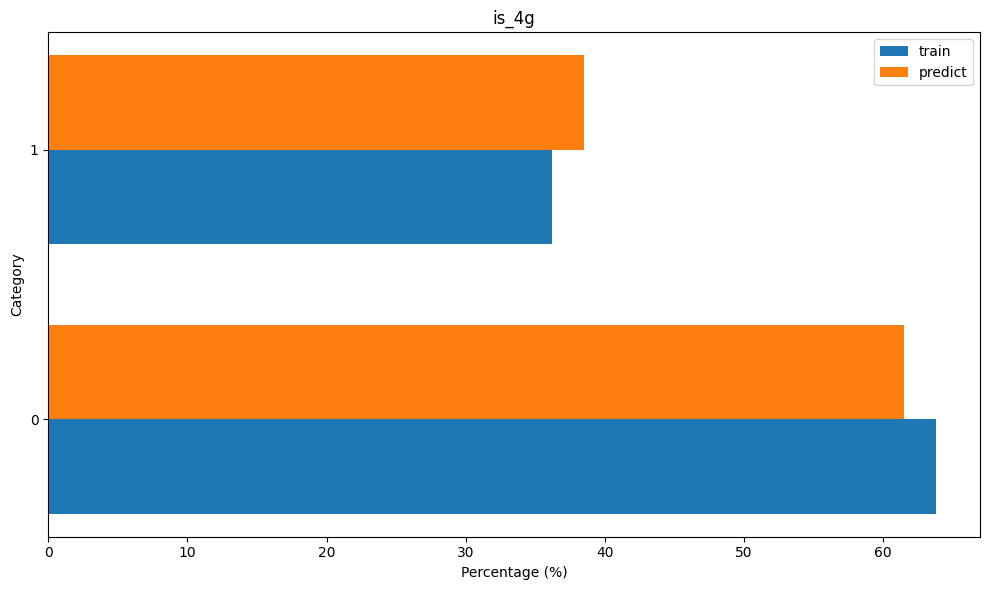

In [89]:
count_plot(df_train, df_predict, 'is_4g')

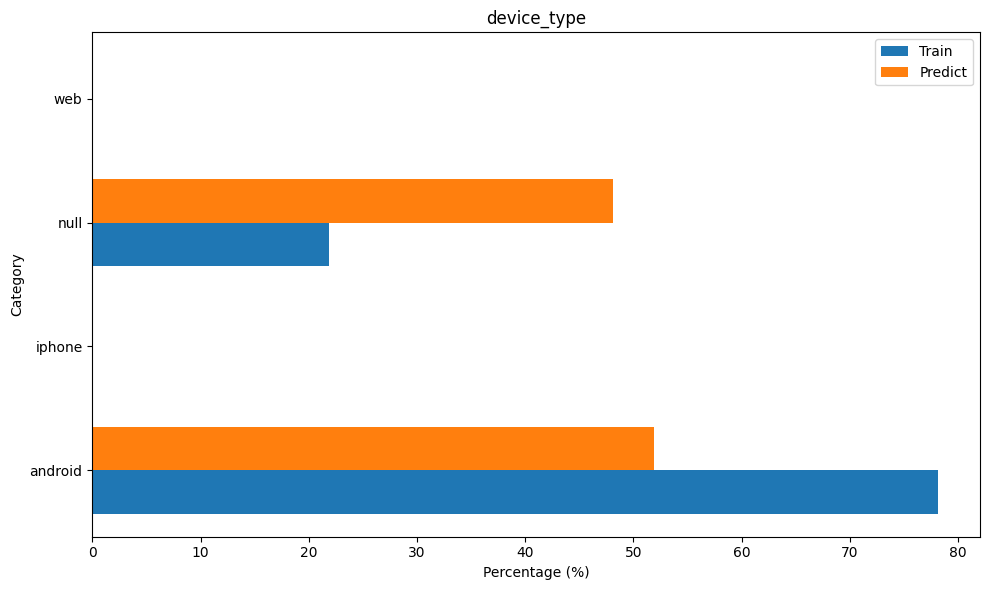

In [19]:
count_plot(df_train, df_predict, 'device_type')

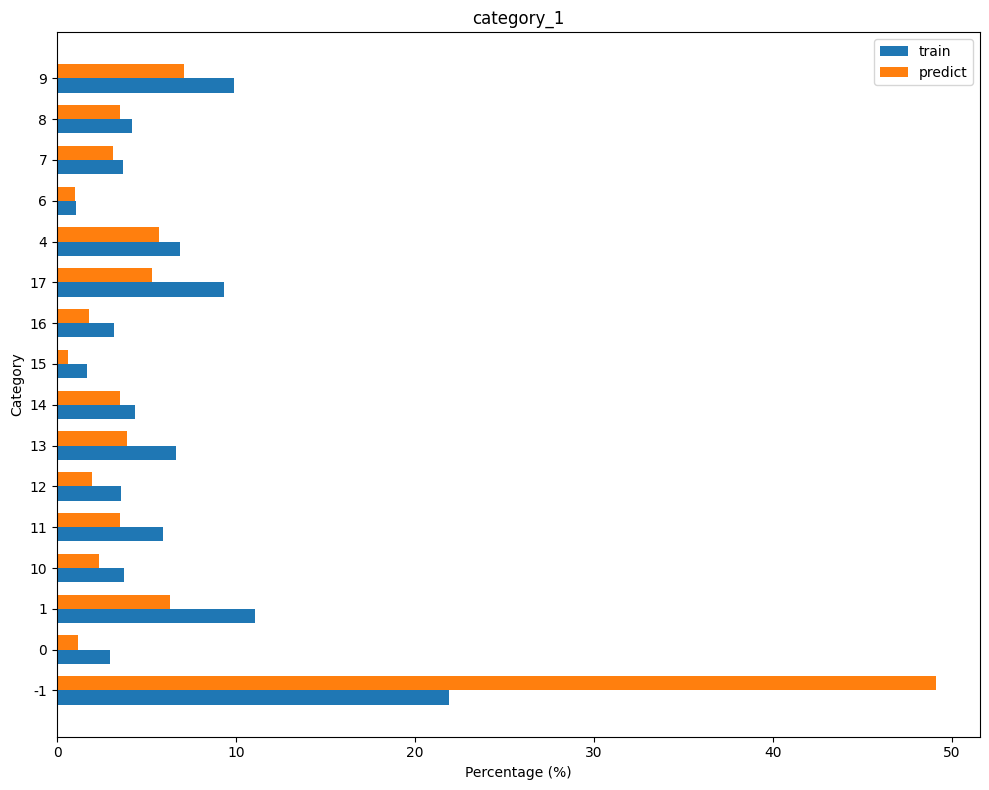

In [92]:
count_plot(df_train, df_predict, 'category_1')

## 2つのモデルを比較

In [3]:
df_ab = wr.athena.read_sql_query(
    "select * from mlops_db.predict_log",
    database=GLUE_DATABASE, 
    ctas_approach=False,
)

In [4]:
df_ab.groupby('model_name')["prediction"].describe()

,count,mean,std,min,25%,50%,75%,max
model_name,,,,,,,,
lightgbm_ctr,490.0,0.037201,0.017779,0.022785,0.022785,0.030428,0.044743,0.098333
sgd_classifier_ctr,509.0,0.041277,0.031254,0.003883,0.011800,0.038729,0.058846,0.211655


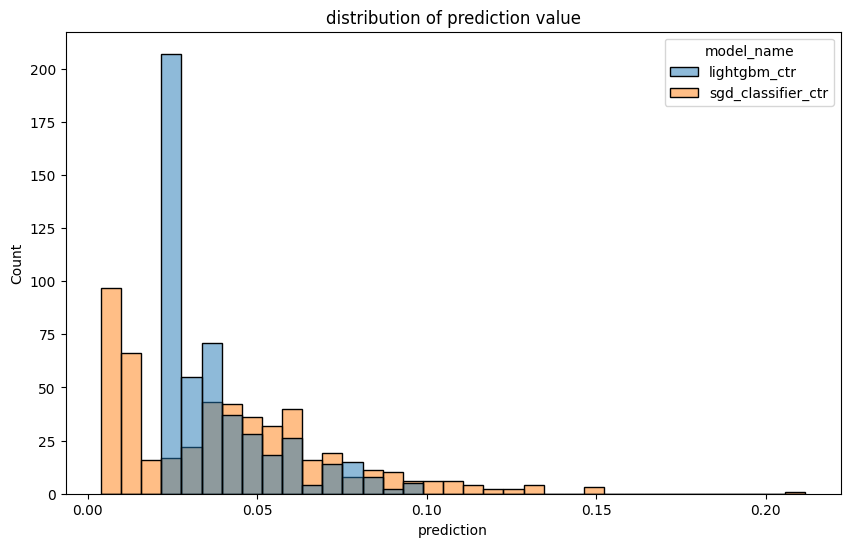

In [27]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df_ab, x="prediction", hue="model_name")
plt.title("distribution of prediction value")
plt.savefig("tmp.png")
plt.show()


## 予測値を再現

In [42]:
sql = """
    select *
    from mlops_db.{table_name}
    where model_name = '{model_name}' 
      and model_version = '{model_version}'
      and data_type = '{data_type}'
"""

df_test = wr.athena.read_sql_query(
    sql.format(table_name='train_log', model_name='lightgbm_ctr', model_version='20250502220511', data_type='test'), 
    database=GLUE_DATABASE, 
    ctas_approach=False,
)

In [43]:
from mlops.aws import get_latest_model_version, get_model_s3_key
from mlops.global_constants import MODEL_REGISTRY_DYNAMODB_TABLE
from mlops.model import get_model_config

model_s3_key = get_model_s3_key(table=MODEL_REGISTRY_DYNAMODB_TABLE, model='lightgbm_ctr', version='20250502220511')
model_config = get_model_config(model_name=model_name)
model = model_config.model_class.from_pretrained(s3_key=model_s3_key)


In [48]:
for schema in model_config.schemas:
    df_test[schema.name] = df_test[schema.name].astype(schema.dtype)
df_test = df_test[[schema.name for schema in model_config.schemas]]
df_test['prediction'] = model.predict_proba(df_test)

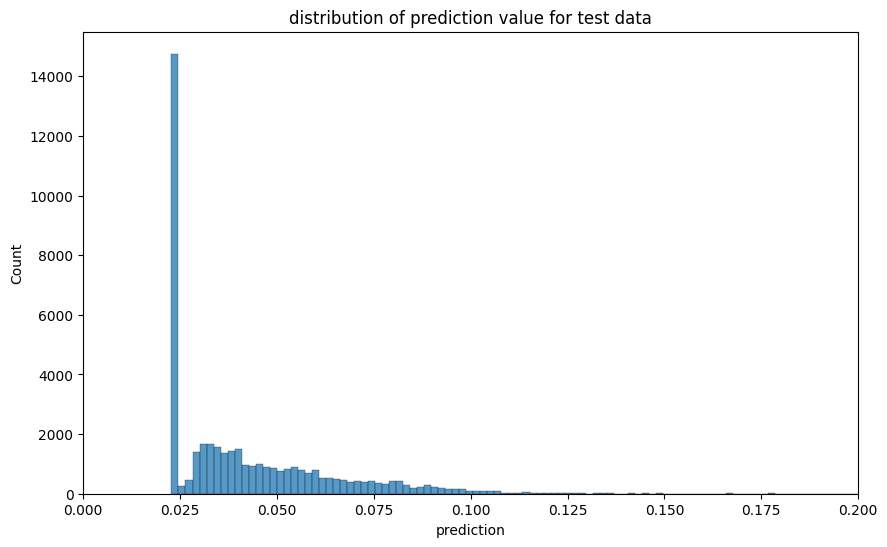

In [54]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df_test, x="prediction")
plt.title("distribution of prediction value for test data")
plt.xlim(0, 0.2)
plt.show()
